In [1]:
import pdal
import smrf

import rasterio

import matplotlib.pyplot as plt
import numpy as np

# Using PDAL's internal SMRF

PDAL's implementation of SMRF is different than Pingel's SMRF version in that it uses a different spatial interpolator during the processing.

In [2]:
fn_in = 'data/USGS_LPC_VA_FEMA-NRCS_SouthCentral_2017_D17_17SNB23501450.laz'

# Commands can be chaned together with the pipe:
pipeline = pdal.Reader(fn_in) | pdal.Filter.smrf(slope=0.15,threshold=0.5,window=5,cell=1,scalar = 1.25)
# Or added afterward like so:
pipeline |= pdal.Writer(filename='out/pdal.classified.laz')
count = pipeline.execute()

# Running Python SMRF

Unlike this above, this uses Pingel's version of SMRF.

In [3]:
fn_in = 'data/USGS_LPC_VA_FEMA-NRCS_SouthCentral_2017_D17_17SNB23501450.laz'

# Commands can be chaned together with the pipe:
pipeline = pdal.Reader(fn_in).pipeline()
pipeline.execute()

arr = pipeline.arrays[0]

In [4]:
Z,T,obj_cells,obj_array = smrf.smrf(arr['X'],arr['Y'],arr['Z'],cellsize=1,windows=5,slope_threshold=.15,
                                            elevation_threshold=.5,elevation_scaler=1.25,
                                            low_filter_slope=1,low_outlier_fill=False,return_extras=False)

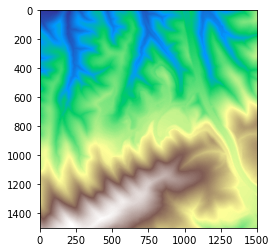

In [5]:
plt.imshow(Z,cmap='terrain')

In [6]:
# Write out DTM with rasterio

with rasterio.open('out/smrf.dtm.tif', 'w', driver='GTiff', 
                             height=Z.shape[0], width=Z.shape[1], crs="epsg:6346",
                             count=1, dtype=np.float32, transform=T) as src:
    src.write(Z.astype(np.float32), 1)

In [7]:
# Write out classified points.  This overwrites classification.  You may not want to do this and should
# adjust accordingly.

new_class = np.ones_like(arr['Classification'])
new_class[~obj_array] = 2

arr['Classification'] = new_class

pipeline2 = pdal.Writer.las(
    filename="out/smrf.classified.laz",
    forward="all",
).pipeline(arr)

pipeline2.execute()

25892612